# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Sourcing and Loading

###  Load relevant libraries 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
cigData= pd.read_csv("CowboyCigsData.csv", index_col=0)
cigData.head()

Time  #CigSales
0  1949-01    1000112
1  1949-02    1000118
2  1949-03    1000132
3  1949-04    1000129
4  1949-05    1000121

In [5]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [6]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

In [8]:
cigData.isnull().sum()

Time         0
#CigSales    0
dtype: int64

## Cleaning, transforming and visualizing

In [9]:
cigData.rename(columns={'Time':'Month'}, inplace=True)

In [10]:
cigData.head()

Month  #CigSales
0  1949-01    1000112
1  1949-02    1000118
2  1949-03    1000132
3  1949-04    1000129
4  1949-05    1000121

### Type conversions 

In [11]:
cigData['Month']=pd.to_datetime(cigData['Month'])
cigData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      144 non-null    datetime64[ns]
 1   #CigSales  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.4 KB


In [12]:
cigData.set_index('Month', inplace=True)
cigData.head()

#CigSales
Month                
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121

### Making a predictor variable `y`

In [65]:
y=cigData['#CigSales']
type(y)

pandas.core.series.Series

### Getting summary statistics for `y`

In [15]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

###  Plotting `y`

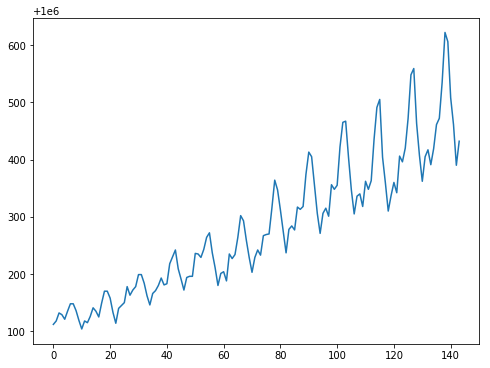

In [66]:
y.plot(figsize=(8,6))

## Modelling 
### Decomposition

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

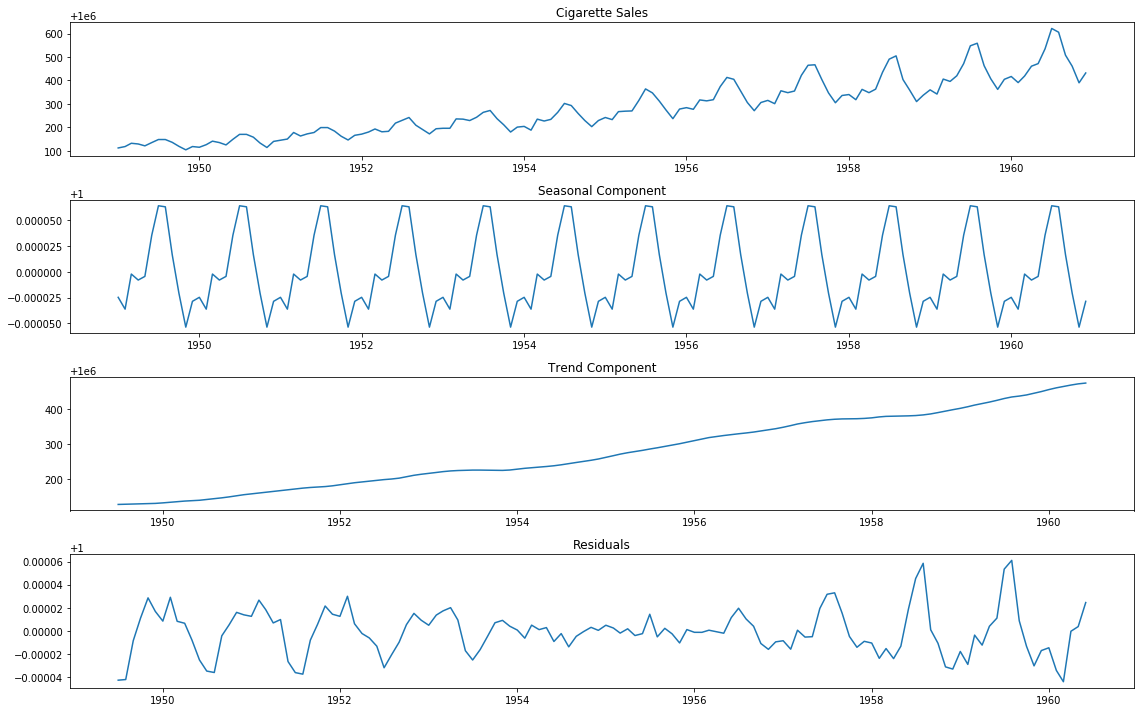

In [20]:
decomp = seasonal_decompose(y, model='multiplicative')
plt.figure(figsize=(16, 10))
plt.subplot(411)
plt.plot(y, label = '#CigSales')
plt.title('Cigarette Sales')
plt.subplot(412)
plt.plot(decomp.seasonal, label = 'Seasonal')
plt.title('Seasonal Component')
plt.subplot(413)
plt.plot(decomp.trend, label = 'Trend')
plt.title('Trend Component')
plt.subplot(414)
plt.plot(decomp.resid, label = 'Residuals')
plt.title('Residuals')
plt.tight_layout();

### Testing for stationarity with KPSS

In [22]:
from statsmodels.tsa.stattools import kpss
result= kpss(y)
print(f"p-value: {result[1]}")
result

p-value: 0.01


C:\Users\laptop\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\laptop\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(1.0521750110138661,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

###  Making the data stationary 
Let's recall what it looks like. 

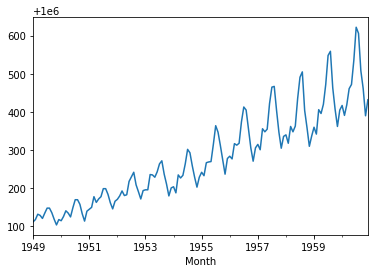

In [23]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [24]:
y_log=np.log(y)

**NOTE 1:**

When you plot this, you can see how the variance in our data now remains contant over time.
**IT DOESN'T HAVE CONSTANT VARIANCE??**

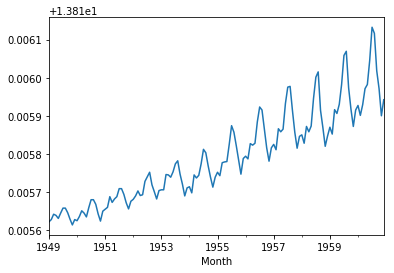

In [25]:
y_log.plot()

In [51]:
result_log= kpss(y_log)
print(f"p-value: {result_log[1]}")
result_log       # NOT STATIONARY

p-value: 0.01


(1.0521822892904293,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [26]:
y_log_diff= y_log.diff()
y_log_diff.dropna(inplace=True)
result= kpss(y_log_diff)
print(f"p-value: {result[1]}")
result   # p-value > 0.05  ---> STATIONARY

p-value: 0.1


C:\Users\laptop\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.05301079859857676,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

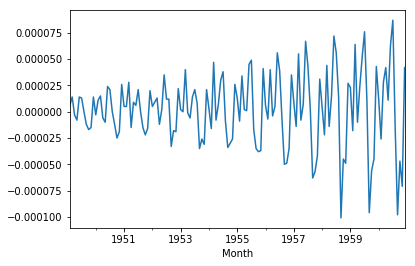

In [27]:
y_log_diff.plot()
plt.show()

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

**NOTE 2:**

**ALTHOUGH THE P-VALUE INDICATES IT IS STATIONARY, THE VARIANCE IS NOT CONSTANT?** 

In [28]:
y_log_diff12=  y_log_diff.diff(periods=12).dropna()
result12= kpss(y_log_diff12)
print(f"p-value: {result12[1]}")
kpss(y_log_diff12)

p-value: 0.1


C:\Users\laptop\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\laptop\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.08678962071184537,
 0.1,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

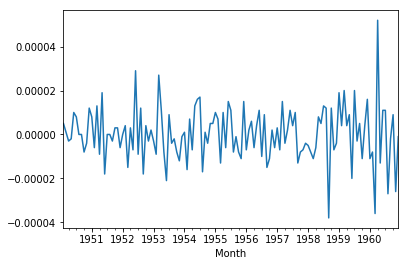

In [29]:
y_log_diff12.plot()

###  The ARIMA model

In [30]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_sarima_model(data, arima_order, seasonal_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = []
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = SARIMAX(past, order=arima_order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]  ## predict() requires start and dates!!!
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [32]:
import warnings
warnings.filterwarnings('ignore')
arima_order, seasonal_order =(0,1,0), (1,1,1,12)
evaluate_sarima_model(y_log,arima_order, seasonal_order)

3.2275920176815593e-10

# BEST MODEL WITH ITERATION

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [34]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def sarima_params(dataset, p_values, d_values, q_values, P_values,D_values,Q_values):
    best_score, best_cfg, best_seasonal = np.Inf, (0,0,0), (0,0,0,12)
    # Iterate through p_values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            arima_order = (p,d,q)
                            seasonal_order =(P,D,Q,12)
                            try:
                                
                                # Make a variable called mse for the Mean squared error
                                mse= evaluate_sarima_model(dataset, arima_order,seasonal_order)               
                                if mse < best_score:
                                    best_score, best_cfg, best_seasonal = mse, arima_order, seasonal_order
                                print('SARIMA', arima_order, seasonal_order,mse)
                            except:
                                continue                   
                            
                # p, d, q iterator variables in that order
                
    return print('Best SARIMA', best_score, best_cfg, best_seasonal)
    #return print(best_score, best_cfg, best_seasonal)

In [35]:
# Now, we choose a couple of values to try for each parameter.
p=d=q=P=D=Q= [i for i in range(3)]

In [36]:
# Since iteration took a long time only the result screen shot is added.

# sarima_params(y_log,p,d,q,P,D,Q)

**ITERATION RESULT :**

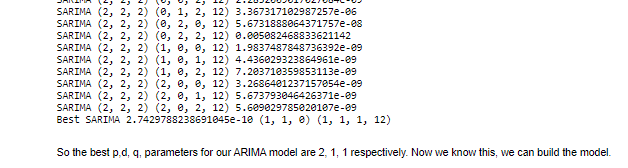

**BEST SARIMAX : (1,1,0)(1,1,1,12)  and  MSE score: 2.7430**

# BEST MODEL WITH ACF, PACF

**PLOT ACF AND PACF AFTER GETTING DATA STATIONARY!!**

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**NOTE 3:**

<Figure size 1080x720 with 0 Axes>

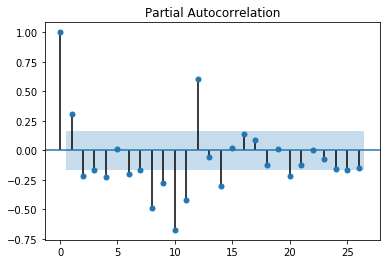

In [69]:
plt.figure(figsize=(15,10))
plot_pacf(y_log_diff, lags=26)
plt.show()

**S is equal to the ACF lag with the highest value (typically at a high lag).There is a big value at lag 12 in the ACF plot which suggests our season is S = 12 and since this lag is positive it suggests P = 1 and Q = 0.**

**P≥1 if the ACF is positive at lag S, else P=0.
Q≥1 if the ACF is negative at lag S, else Q=0.**

<Figure size 1080x864 with 0 Axes>

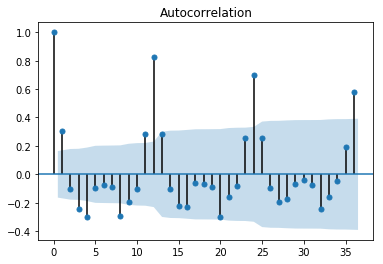

In [66]:
plt.figure(figsize=(15,12))
plot_acf(y_log_diff, lags=36)
plt.show()

# BEST MODEL WITH  AUTO_ARIMA

**ONE HANDICAP: IT DOESN"T TAKE LOG TRASFORMATION**
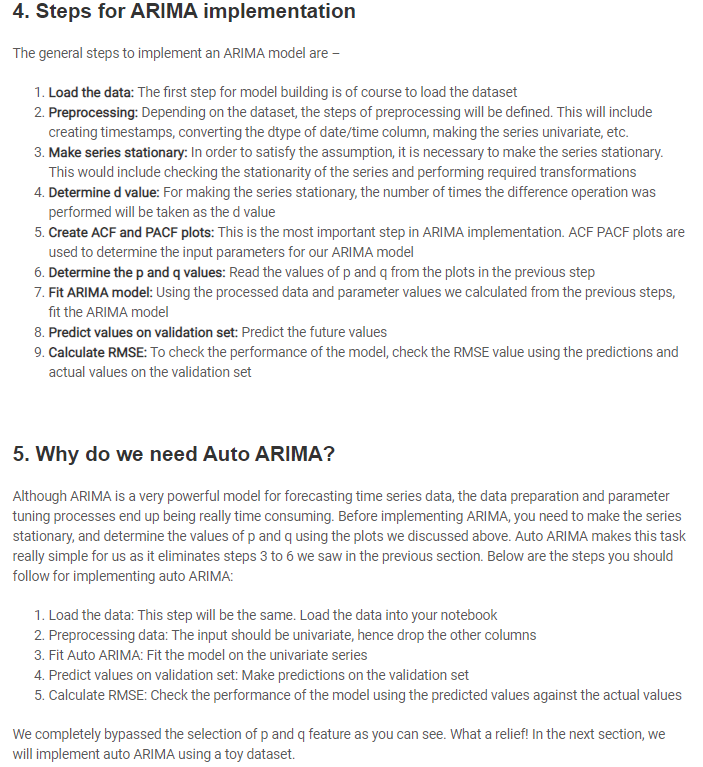

In [41]:
!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima

In [43]:
train=cigData[:int(len(cigData)* 0.8)]

In [74]:
model_auto=auto_arima(train, m=12, trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.888, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.157, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=756.376, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=757.881, Time=0.29 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.885, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.995, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.634, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=757.671, Time=0.14 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=757.421, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.052, Time=0.10 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=759.420, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AI

In [75]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -374.944
Date:                            Fri, 30 Apr 2021   AIC                            755.888
Time:                                    03:59:55   BIC                            763.763
Sample:                                         0   HQIC                           759.077
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1196      0.080     -1.503      0.133      -0.276       0.036
ar.S.L12      -0.1147      0.082     -1.407      0.159      -0.274       0.045
sigma2        89.2380     13.670      6.528      0.000      62.445     116.031
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.50   Prob(JB):                         0.21
Heteroskedasticity (H):               1.03   Skew:                             0.40
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=757.509, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.888, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.157, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=756.376, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=757.881, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.885, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.995, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.634, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=757.671, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=757.421, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.052, Time=0.12 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=759.420, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

**QUESTION:** What happens to log in ARIMA?? We didn't use log transformation. We implemented raw data in auto_arima.  SHOULD WE USE RAW DATA OR "LOG-DATA"?

**IT LOOKS AS IF AUTO_ARIMA IS NOT EFFECTIVE FOR DETAIL ANALYSIS.**

In [46]:
model_log=auto_arima(y_log, m=12, trace= True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-2509.325, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2536.258, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2533.872, Time=0.86 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2512.025, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-2587.536, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-2556.286, Time=0.62 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-2557.480, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-2559.489, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-2555.978, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-2504.214, Time=0.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-2552.856, Time=0.83 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=-2544.384, Time=1.77 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 7.471 seconds


# COMPARISON OF BEST MODELS:

**Lower AIC, BIC, HQIC means better model.**
**2.Model (1,1,1)(1,1,0,12)  has the lowest AIC, BIC, HQIC scores. So we will continue with this model**

1.MODEL: ACCORDING TO 'MSE' ITERATION WITH "y_log" : (1,1,0)(1,1,1,12)

2.MODEL: ACCORDING TO ACF-PACF PLOTS WITH "y_log_diff": (1,1,1)(1,1,0,12)

3.MODEL: ACCORDING TO AUTO_ARIMA WITH "raw data" :  (1,1,0) (1,1,0,12)

In [122]:
split= int(len(cigData)*0.8)
y_log_train= y_log[:split]
y_log_test = y_log[split:len(cigData)]

**1.MODEL:**

In [123]:
model_1 =SARIMAX(y_log_train, order=(1,1,0), seasonal_order=(1,1,1,12),
                 enforce_invertibility=False)
model_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            #CigSales   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 970.555
Date:                              Fri, 30 Apr 2021   AIC                          -1933.110
Time:                                      06:13:16   BIC                          -1922.610
Sample:                                  01-01-1949   HQIC                         -1928.858
                                       - 07-01-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2064   2.75e-19   -7.5e+17      0.000      -0.206      -0.206
ar.S.L12       0.0721    1.8e-19   4.01e+17      0.000       0.072       0.072
ma.S.L12      -0.2025   1.76e-19  -1.15e+18      0.000      -0.202      -0.202
sigma2          1e-10   2.08e-10      0.480      0.631   -3.08e-10    5.08e-10
===================================================================================
Ljung-Box (L1) (Q):                   5.19   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.02   Prob(JB):                         0.57
Heteroskedasticity (H):               1.10   Skew:                             0.26
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+35. Standard errors may be unstable.
"""

**2.MODEL:**

In [124]:
#    NOTE: Although we used y_log_diff for ACF,PACF plot we use y_log for calculation    
model_2 =SARIMAX(y_log_train, order=(1,1,1), seasonal_order=(1,1,0,12),
                 enforce_invertibility=False)
model_2_fit= model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           #CigSales   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 980.374
Date:                             Fri, 30 Apr 2021   AIC                          -1952.747
Time:                                     06:13:25   BIC                          -1942.247
Sample:                                 01-01-1949   HQIC                         -1948.496
                                      - 07-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8428   2.92e-20  -2.89e+19      0.000      -0.843      -0.843
ma.L1          0.6694    4.5e-20   1.49e+19      0.000       0.669       0.669
ar.S.L12      -0.1810   1.04e-19  -1.74e+18      0.000      -0.181      -0.181
sigma2      5.466e-10   2.63e-10      2.080      0.038    3.16e-11    1.06e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.87   Prob(JB):                         0.26
Heteroskedasticity (H):               1.26   Skew:                             0.32
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.83e+35. Standard errors may be unstable.
"""

**3.MODEL:**

In [77]:
model_3= model_auto
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -374.944
Date:                            Fri, 30 Apr 2021   AIC                            755.888
Time:                                    04:01:49   BIC                            763.763
Sample:                                         0   HQIC                           759.077
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1196      0.080     -1.503      0.133      -0.276       0.036
ar.S.L12      -0.1147      0.082     -1.407      0.159      -0.274       0.045
sigma2        89.2380     13.670      6.528      0.000      62.445     116.031
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 3.15
Prob(Q):                              0.50   Prob(JB):                         0.21
Heteroskedasticity (H):               1.03   Skew:                             0.40
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

**predict() is used for in-sample predictions and forecast() is just for out-of-sample predictions.**

In [141]:
length=int(len(y_log) * 0.2)
print(length)
model_2_predict= model_2_fit.get_prediction(start=-length, end=len(y_log))
mean_predict= model_2_predict.predicted_mean

28


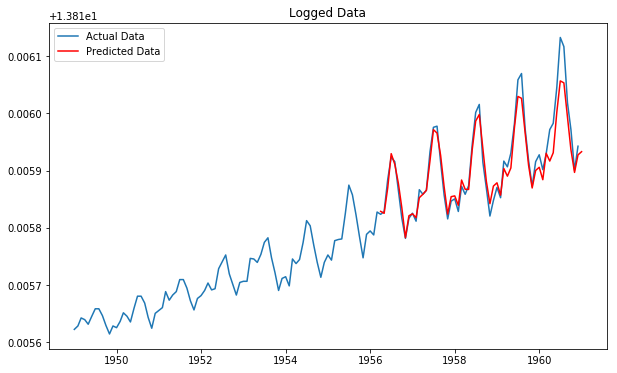

In [169]:
plt.figure(figsize=(10,6))
plt.plot(y_log, label='Actual Data')
plt.plot(mean_predict, color = 'red', label='Predicted Data')
plt.title('Logged Data')
plt.legend()
plt.show()

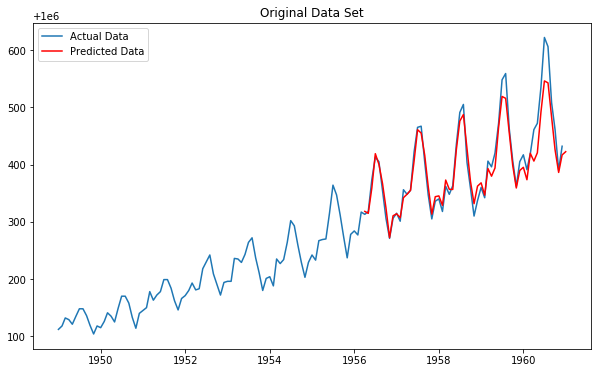

In [170]:
# Transform to Actual Data
origin_predict= np.exp(mean_predict)
plt.figure(figsize=(10,6))
plt.plot(cigData, label='Actual Data')
plt.plot(origin_predict, color = 'red', label='Predicted Data')
plt.title('Original Data Set')
plt.legend()
plt.show()

### 3f. Application: Forecasting

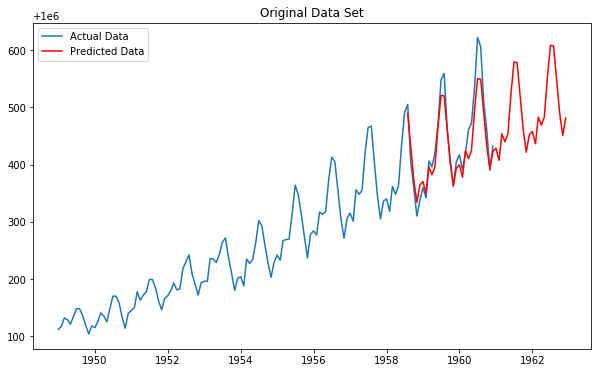

In [215]:
forecast_period= 53
forecast_result= model_2_fit.get_forecast(steps=forecast_period)
mean_forecast= forecast_result.predicted_mean
original_forecast= np.exp(mean_forecast)

plt.figure(figsize=(10,6))
plt.plot(cigData, label='Actual Data')
plt.plot(original_forecast, color = 'red', label='Predicted Data')
plt.title('Original Data Set')
plt.legend()
plt.show()

In [216]:
d= pd.DataFrame(original_forecast)
d.tail()

predicted_mean
1962-08-01    1.000607e+06
1962-09-01    1.000548e+06
1962-10-01    1.000491e+06
1962-11-01    1.000451e+06
1962-12-01    1.000481e+06

# ANALYSIS WITH PROPHET

In [30]:
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_cross_validation_metric
import matplotlib.pyplot as plt
import plotly.offline as py
from fbprophet.diagnostics import cross_validation, performance_metrics

py.init_notebook_mode()
%matplotlib inline

In [31]:
df_prop= pd.read_csv("CowboyCigsData.csv", index_col=0,header=0, names=['ds','y'])
df_prop['y']= df_prop['y']-1000000
df_prop.head()

ds    y
0  1949-01  112
1  1949-02  118
2  1949-03  132
3  1949-04  129
4  1949-05  121

In [32]:
split= int(len(df_prop)*0.8)
train= df_prop.iloc[:split]
test = df_prop.iloc[split:len(df_prop)]

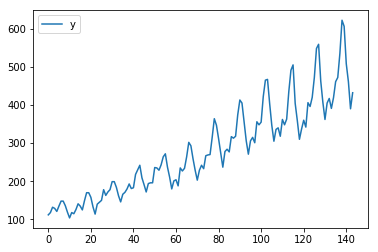

In [33]:
df_prop.plot()

**Additive (6.1) and Multiplicative with additonal seasonality (6.4) are created to see the difference between the models.**

## Additive Model

In [34]:
pro=Prophet()
pro.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
cigData.tail()

Time  #CigSales
139  1960-08    1000606
140  1960-09    1000508
141  1960-10    1000461
142  1960-11    1000390
143  1960-12    1000432

In [36]:
future= pro.make_future_dataframe(periods=12*2, freq='MS')   # "MS" 1st day of the month

In [37]:
forecast=pro.predict(future)
forecast[['ds','yhat_lower','yhat_upper','yhat']].tail()

ds  yhat_lower  yhat_upper        yhat
134 1960-03-01  444.039882  487.984183  465.994360
135 1960-04-01  436.504472  480.659800  458.590216
136 1960-05-01  435.778499  478.540092  458.491145
137 1960-06-01  478.038489  521.380856  498.576231
138 1960-07-01  505.323802  548.012671  526.296843

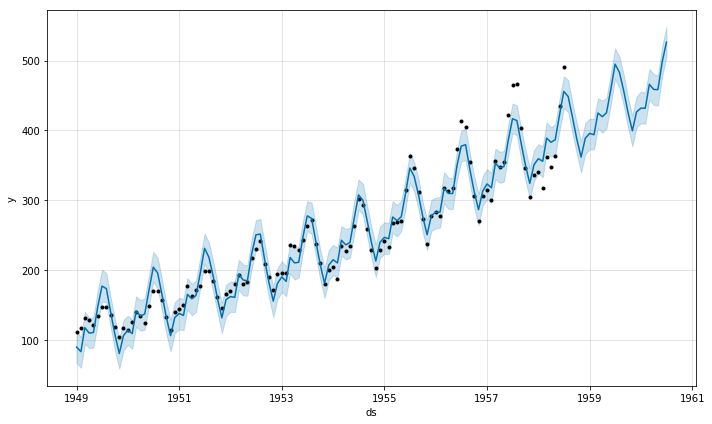

In [38]:
fig=pro.plot(forecast)  # black dot >> actual data    blue line >> predicted data

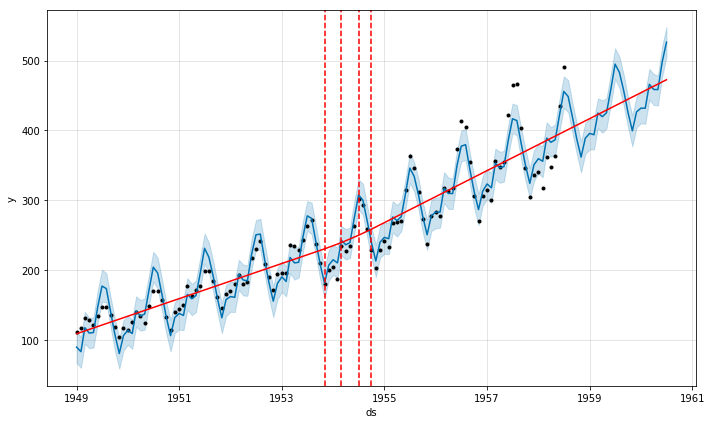

In [39]:
fig=pro.plot(forecast) 
a = add_changepoints_to_plot(fig.gca(), pro, forecast)

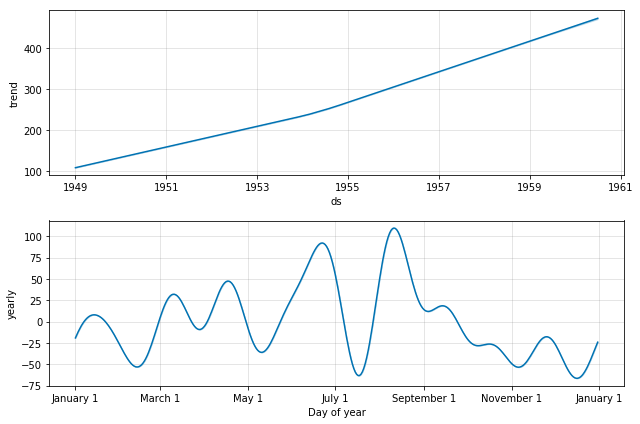

In [40]:
fig2= pro.plot_components(forecast)

**NOTE : 4**

SHOULD WE FIT THE MODEL ON TRAIN SET OR WHOLE SET? 

## Multiplicative Model (Trained with whole data set)

Multiplicative predicts better than Additive Model...

In [41]:
pro_new= Prophet(seasonality_mode='multiplicative')
pro_new.fit(df_prop)
future_new= pro_new.make_future_dataframe(periods=12*2, freq='MS')
future_new.tail()
# actual data: (1949-01)-(1960-12)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
163 1962-08-01
164 1962-09-01
165 1962-10-01
166 1962-11-01
167 1962-12-01

In [42]:
forecast_new=pro_new.predict(future_new)
forecast_new[['ds','yhat_lower','yhat_upper','yhat']].tail()

ds  yhat_lower  yhat_upper        yhat
163 1962-08-01  693.285326  722.160588  707.275007
164 1962-09-01  585.153858  614.026304  599.904811
165 1962-10-01  510.641868  539.549898  525.807438
166 1962-11-01  443.685898  471.059056  457.815178
167 1962-12-01  497.872464  526.771128  511.578275

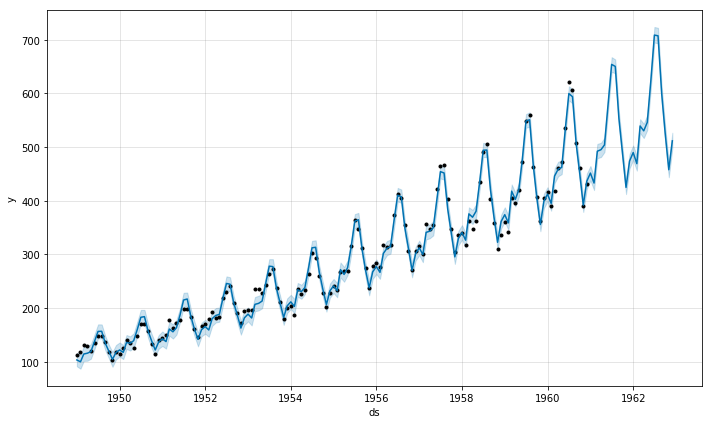

In [43]:
fig_new=pro_new.plot(forecast_new)

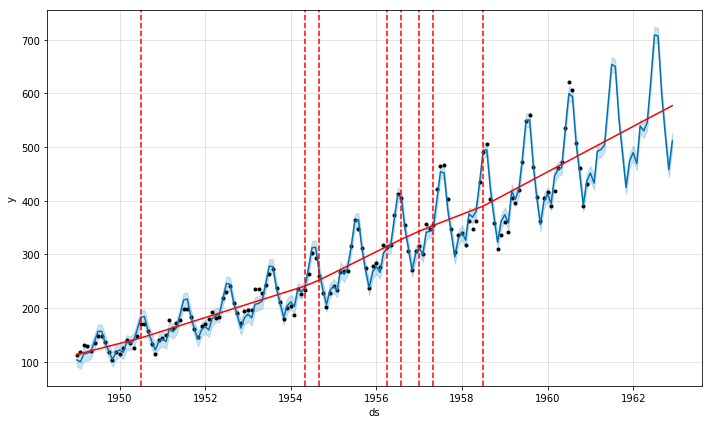

In [44]:
fig_new=pro_new.plot(forecast_new)
a_new = add_changepoints_to_plot(fig_new.gca(), pro_new, forecast_new)

In [45]:
df_cv= cross_validation(pro_new, initial='1095 days', period = '180 days', horizon = '365 days')
# actual data: (1949-01)-(1960-12)
# add 730 days to beginning point of the data (1949-01) 
df_cv.head()

INFO:fbprophet:Making 17 forecasts with cutoffs between 1952-01-13 00:00:00 and 1959-12-02 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1952-02-01  173.888522  170.713300  176.937099  180 1952-01-13
1 1952-03-01  201.929726  199.047798  205.217532  193 1952-01-13
2 1952-04-01  207.087101  203.915073  210.224267  181 1952-01-13
3 1952-05-01  176.337203  173.197903  179.386138  183 1952-01-13
4 1952-06-01  215.155754  212.003958  218.469767  218 1952-01-13

In [46]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper    y     cutoff
199 1960-08-01  573.578381  560.230535  586.270029  606 1959-12-02
200 1960-09-01  496.395279  484.198967  509.016813  508 1959-12-02
201 1960-10-01  433.175028  420.169693  446.880007  461 1959-12-02
202 1960-11-01  379.492734  366.294263  392.544147  390 1959-12-02
203 1960-12-01  420.445224  407.268081  432.951418  432 1959-12-02

In [47]:
performance_metrics(df_cv)

horizon         mse       rmse        mae      mape     mdape  coverage
0    40 days  340.430292  18.450753  14.696699  0.048740  0.034517      0.30
1    42 days  332.154663  18.225111  14.211400  0.046429  0.032597      0.35
2    46 days  280.944214  16.761391  13.315055  0.044531  0.032597      0.35
3    47 days  294.635495  17.164950  14.082742  0.046089  0.034517      0.30
4    48 days  250.859761  15.838553  12.983868  0.044660  0.034517      0.30
..       ...         ...        ...        ...       ...       ...       ...
153 359 days  655.561108  25.603928  19.791165  0.059539  0.049431      0.35
154 360 days  655.945248  25.611428  19.868592  0.059898  0.049431      0.35
155 362 days  695.021909  26.363268  20.630600  0.058523  0.049431      0.35
156 364 days  665.882654  25.804702  19.761007  0.056673  0.046675      0.35
157 365 days  689.578718  26.259831  19.996633  0.057835  0.040557      0.40

[158 rows x 7 columns]

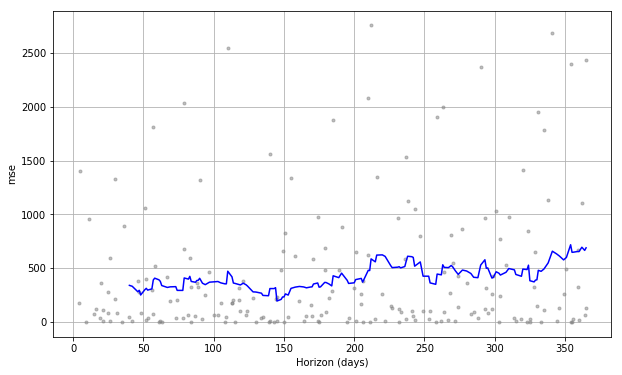

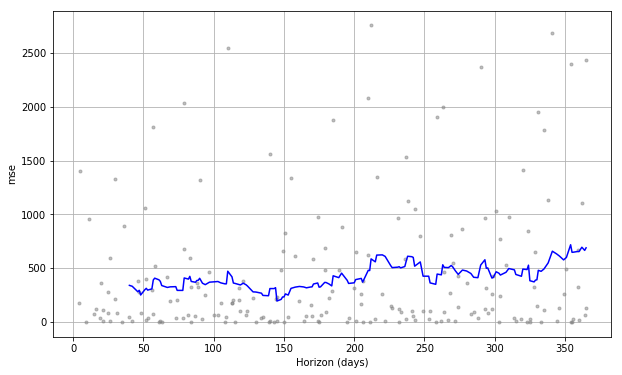

In [49]:
plot_cross_validation_metric(df_cv, metric='mse')

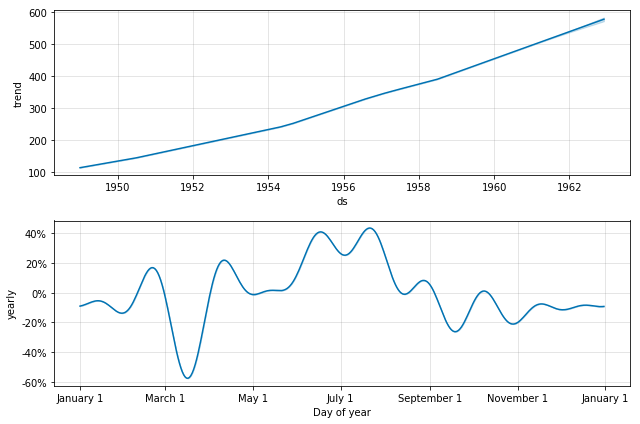

In [50]:
fig2_new= pro_new.plot_components(forecast_new)

## Multiplicative Model (Trained with train data set)

When compared to model with the whole data set this model predicts better.

MSE graph shows lower scores than the above.

**NOTE 5:**

WHY THE MODELS 6.2 AND 6.3 HAVE DIFFERENT CHANGEPOINTS?

**NOTE 6:**

HOW SHOULD I INTERPRETE THE performance_metrics RESULTS? IT DOESN'T GIVE A SPECIFIC MAE, MSE RESULT.

In [64]:
pro_new= Prophet(seasonality_mode='multiplicative')
#pro_new.add_seasonality(name='monthly', period=30.5, fourier_order=5)
pro_new.fit(train)
future_new= pro_new.make_future_dataframe(periods=12*2, freq='MS')   # "MS" 1st day of the month
forecast_new=pro_new.predict(future_new)
forecast_new[['ds','yhat_lower','yhat_upper','yhat']].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds  yhat_lower  yhat_upper        yhat
134 1960-03-01  442.953729  467.621259  455.320546
135 1960-04-01  427.011674  451.876130  440.110895
136 1960-05-01  428.347981  453.516787  441.383521
137 1960-06-01  502.499596  528.904419  515.477942
138 1960-07-01  550.924052  578.527433  564.212165

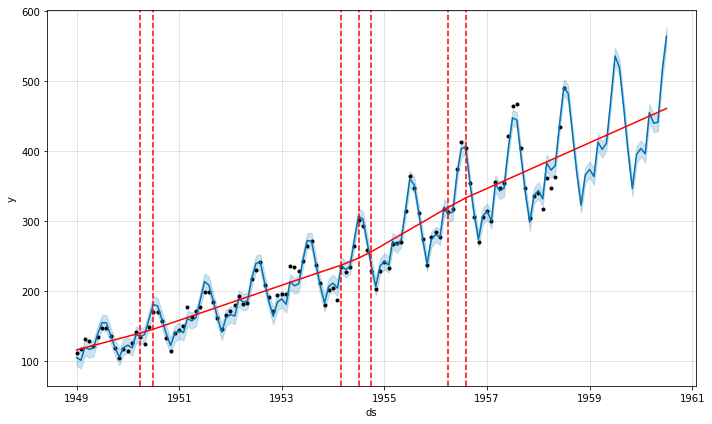

In [52]:
fig_new=pro_new.plot(forecast_new)
a_new = add_changepoints_to_plot(fig_new.gca(), pro_new, forecast_new)

In [53]:
df_cv= cross_validation(pro_new,  initial='1095 days', period = '180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 1952-01-29 00:00:00 and 1957-07-01 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1952-02-01  173.888522  170.737159  177.128928  180 1952-01-29
1 1952-03-01  201.929726  198.804923  205.209179  193 1952-01-29
2 1952-04-01  207.087101  203.997656  210.307340  181 1952-01-29
3 1952-05-01  176.337203  173.102365  179.579499  183 1952-01-29
4 1952-06-01  215.155754  211.651215  218.216527  218 1952-01-29

In [54]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper    y     cutoff
139 1958-03-01  407.251162  398.336549  416.007435  362 1957-07-01
140 1958-04-01  398.350009  389.202321  406.856067  348 1957-07-01
141 1958-05-01  402.169957  393.233782  411.183410  363 1957-07-01
142 1958-06-01  459.234849  449.609162  468.098233  435 1957-07-01
143 1958-07-01  515.806424  506.569039  524.878706  491 1957-07-01

In [55]:
performance_metrics(df_cv)

horizon         mse       rmse        mae      mape     mdape  coverage
0    36 days  213.975812  14.627912  11.322311  0.046527  0.033071  0.214286
1    37 days  213.682738  14.617891  11.297636  0.045847  0.031716  0.214286
2    41 days  211.284533  14.535630  11.173622  0.045389  0.031716  0.214286
3    42 days  228.408893  15.113203  11.607099  0.046223  0.031716  0.214286
4    46 days  227.894611  15.096179  11.520704  0.045936  0.031716  0.214286
..       ...         ...        ...        ...       ...       ...       ...
126 355 days  611.073295  24.719897  19.146096  0.058685  0.050794  0.357143
127 359 days  534.478392  23.118789  16.983554  0.050828  0.039588  0.428571
128 360 days  481.838666  21.950824  15.175858  0.045923  0.025787  0.500000
129 364 days  509.214200  22.565775  16.230725  0.048895  0.039588  0.428571
130 365 days  552.204717  23.499037  17.740251  0.051883  0.048199  0.357143

[131 rows x 7 columns]

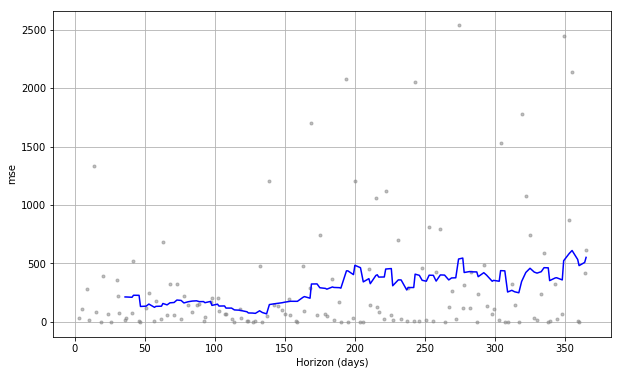

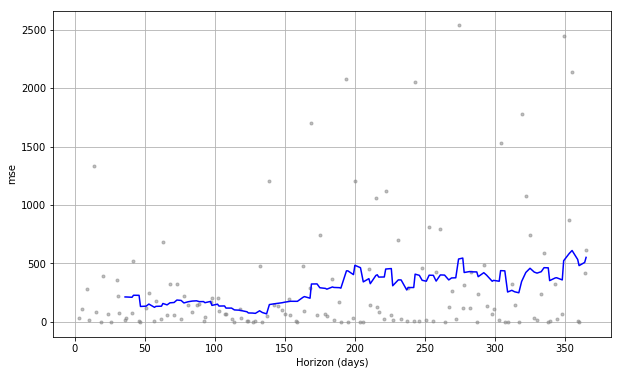

In [56]:
plot_cross_validation_metric(df_cv, metric='mse')

## Additional Seasonality

ADDING ADDITIONAL SEASONALITY HAD BAD EFFECT ON THE MODEL
MSE is MUCH HIGHER THAN PREVIOUS ONES. THE ABOUE IS BELOW 500, THIS MODELS IS AROUND 1500.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


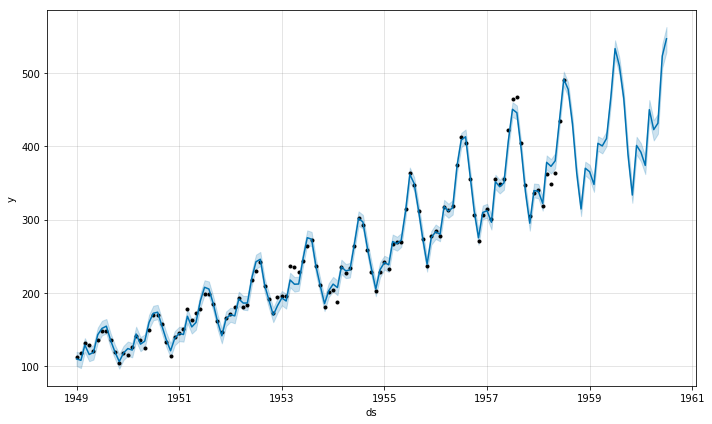

In [57]:
m= Prophet(seasonality_mode='multiplicative')
m.add_seasonality(name='quarterly', period=91.25, fourier_order = 8, mode = 'multiplicative')
m.fit(train)
future_m= m.make_future_dataframe(periods=12*2, freq='MS')   # "MS" 1st day of the month
forecast_m=m.predict(future_m)
fig_m=m.plot(forecast_m)

In [58]:
df_m= cross_validation(m,  initial='1095 days', period = '180 days', horizon = '365 days')
df_m.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 1952-01-29 00:00:00 and 1957-07-01 00:00:00


  0%|          | 0/12 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1952-02-01  159.571439  157.078422  161.944200  180 1952-01-29
1 1952-03-01  108.995604  103.066033  115.021039  193 1952-01-29
2 1952-04-01  149.068795  132.389246  165.584429  181 1952-01-29
3 1952-05-01   55.341970   45.741627   65.108108  183 1952-01-29
4 1952-06-01  146.037206  110.125826  181.195856  218 1952-01-29

In [59]:
df_m.tail()

ds        yhat  yhat_lower  yhat_upper    y     cutoff
139 1958-03-01  408.069885  400.413100  415.454309  362 1957-07-01
140 1958-04-01  406.101543  398.407606  413.776201  348 1957-07-01
141 1958-05-01  409.403026  401.593834  417.661531  363 1957-07-01
142 1958-06-01  466.881440  458.035758  475.459999  435 1957-07-01
143 1958-07-01  528.424666  518.710278  538.576373  491 1957-07-01

In [60]:
performance_metrics(df_m)

horizon          mse       rmse        mae      mape     mdape  coverage
0    36 days   806.163597  28.393020  19.725623  0.091232  0.062935  0.285714
1    37 days   921.959599  30.363788  21.491399  0.096791  0.062935  0.285714
2    41 days   889.020591  29.816448  20.617670  0.093259  0.055092  0.285714
3    42 days   830.139988  28.812150  19.523969  0.086514  0.055092  0.285714
4    46 days   805.410854  28.379761  18.404179  0.082440  0.048307  0.357143
..       ...          ...        ...        ...       ...       ...       ...
126 355 days  1888.608206  43.458120  34.288252  0.127932  0.097520  0.714286
127 359 days  1851.549008  43.029629  33.076408  0.123368  0.093937  0.714286
128 360 days  1738.753643  41.698365  30.994568  0.117333  0.075820  0.714286
129 364 days  1752.836781  41.866894  31.266657  0.117574  0.077505  0.714286
130 365 days  1852.806005  43.044233  33.867127  0.122846  0.078970  0.642857

[131 rows x 7 columns]

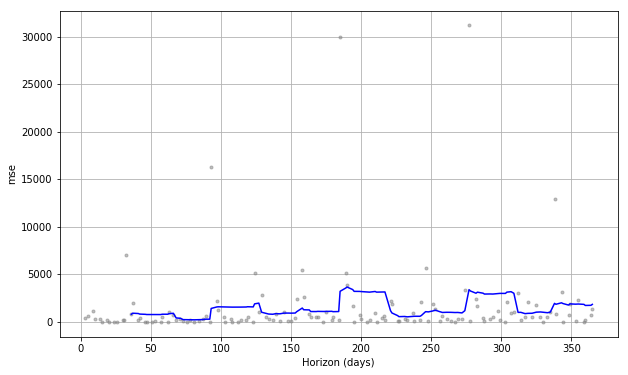

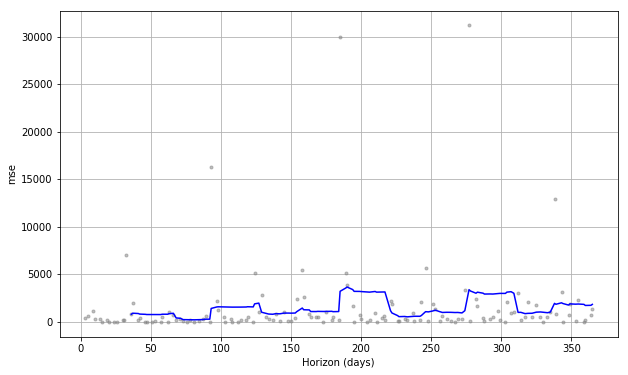

In [61]:
plot_cross_validation_metric(df_m, metric='mse')

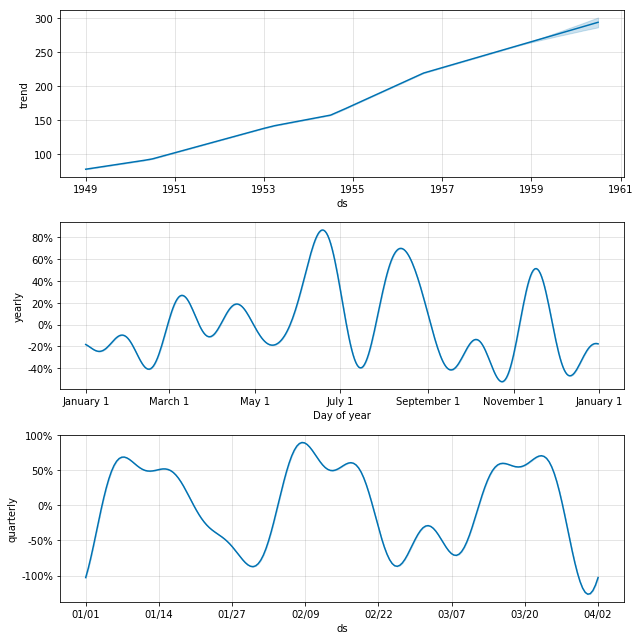

In [62]:
fig2_new= m.plot_components(forecast_m)